In [30]:
import pandas as pd
from torch.utils.data import Dataset

class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx, -1]
        return features, label

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r'water_potability.csv')
df


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.587349,0.577747,0.386298,0.568199,0.647347,0.292985,0.654522,0.795029,0.630115,0
1,0.643654,0.441300,0.314381,0.439304,0.514545,0.356685,0.377248,0.202914,0.520358,0
2,0.388934,0.470876,0.506122,0.524364,0.561537,0.142913,0.249922,0.401487,0.219973,0
3,0.725820,0.715942,0.506141,0.521683,0.751819,0.148683,0.467200,0.658678,0.242428,0
4,0.610517,0.532588,0.237701,0.270288,0.495155,0.494792,0.409721,0.469762,0.585049,0
...,...,...,...,...,...,...,...,...,...,...
2006,0.636224,0.580511,0.277748,0.418063,0.522486,0.342184,0.310364,0.402799,0.627156,1
2007,0.470143,0.548826,0.301347,0.538273,0.498565,0.231359,0.565061,0.175889,0.395061,1
2008,0.817826,0.087434,0.656389,0.670774,0.369089,0.431872,0.563265,0.285745,0.578674,1
2009,0.424187,0.464092,0.459656,0.541633,0.615572,0.388360,0.397780,0.449156,0.440004,1


In [33]:
# Split the dataset into training set and test set
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the training set and test set into csv files
train_df.to_csv('water_train.csv', index=False)
test_df.to_csv('water_test.csv', index=False)

In [34]:
# Create an instance of the WaterDataset
dataset_train = WaterDataset('water_train.csv')

dataset_test = WaterDataset('water_test.csv')

dataset_train

In [35]:
from torch.utils.data import DataLoader

# Create a DataLoader based on dataset_train
# Shuffling the training data is important because it helps to ensure that the model does not learn the order of the data, which can lead to overfitting. By shuffling, you provide the model with a more varied and representative sample of the data in each epoch.
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
)

# Create a DataLoader based on dataset_test
# For the test data, shuffling is generally not necessary and can be avoided. The test set is used to evaluate the model’s performance, and shuffling does not provide any benefit in this context. It is often better to keep the test data in a fixed order to ensure consistent evaluation.
dataloader_test = DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
)

dataloader_train

In [42]:
# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[0.5098, 0.4535, 0.5840, 0.4938, 0.5493, 0.2605, 0.5226, 0.5222, 0.5562],
        [0.5390, 0.5217, 0.2026, 0.4480, 0.6257, 0.3973, 0.6717, 0.3841, 0.3584]],
       dtype=torch.float64) tensor([0., 0.], dtype=torch.float64)


In [43]:
# The benefit of defining a class like Net instead of using nn.Sequential is flexibility. With nn.Sequential, you can only define simple, feed-forward networks where the output from one layer is used as input to the next layer. However, with a custom class, you can define more complex architectures. For example, you can have layers where the output from one layer is used as input to multiple layers, or you can use the output of a layer as input to a previous layer (creating a loop, or recurrent connection).

# In your Net class, you could easily add more complex behavior in the forward method, such as conditionally skipping layers, having multiple input or output layers, changing the order of layers dynamically, etc.

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # As for super(Net, self).__init__(), it’s calling the initialization method of the parent class, which is nn.Module in this case. This is necessary because nn.Module does some behind-the-scenes work that’s necessary for your Net class to function properly with PyTorch, such as keeping track of its trainable parameters and enabling handy methods like to(device) for moving the model to a GPU or eval() for setting the model to evaluation mode. By calling super(Net, self).__init__(), you ensure that your subclass correctly inherits this functionality from nn.Module.
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

In [45]:
labels

tensor([0., 0.], dtype=torch.float64)

In [46]:
labels.shape, labels.view(-1, 1).shape

(torch.Size([2]), torch.Size([2, 1]))

In [48]:
# Loss Calculation: The BCELoss (Binary Cross Entropy Loss) function computes the loss between the model’s raw output probabilities (which can be any value between 0 and 1) and the true labels. It doesn’t require the outputs to be converted into discrete predictions (0 or 1) because it operates on the probability scale. It uses the actual probabilities output by the model to calculate how far off the model’s predictions are from the true labels.

def train_model(optimizer, net, num_epochs):
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        running_loss = 0.
        for features, labels in dataloader_train:
            # Convert features to float32
            features = features.float()
            labels = labels.float()
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels.view(-1, 1)) # labels.view(-1, 1) reshapes the labels tensor to have as many rows as needed (to fit the total number of elements) and 1 column. This is often done to match the expected input/output shape of certain functions or methods. In this case, it’s used to ensure that the labels tensor has the same shape as the outputs tensor, as required by the BCELoss function.
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_loss = running_loss / len(dataloader_train)
    print(f"Training loss after {num_epochs} epochs: {train_loss}")

In [49]:
import torch.optim as optim

net = Net()

# Define the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

Training loss after 10 epochs: 0.6719349748385486


In [52]:
# Accuracy Calculation: Accuracy, on the other hand, is a metric that measures the proportion of correct predictions (both true positives and true negatives) in total predictions made. To calculate accuracy, we need discrete predictions (0 or 1), not probabilities. That’s why the outputs are thresholded at 0.5 to convert them into binary predictions (preds = (outputs >= 0.5).float()). If the output probability is greater than or equal to 0.5, it’s considered a prediction of class 1, otherwise, it’s considered a prediction of class 0.

import torch
from torchmetrics import Accuracy

# Set up binary accuracy metric
acc = Accuracy(task='binary')

net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        # Convert features to float32
        features = features.float()
        labels = labels.float()
        # Get predicted probabilities for test data batch
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

# Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.5732010006904602


In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
        # Apply He initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        # Update ReLU activation to ELU
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

In [55]:
train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

Training loss after 10 epochs: 0.6593251642377222


In [56]:
net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        # Convert features to float32
        features = features.float()
        labels = labels.float()
        # Get predicted probabilities for test data batch
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

# Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.57444167137146


In [57]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Compose transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

train_transforms

Compose(
    ToTensor()
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)

In [58]:
# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    "clouds_train",
    transform=train_transforms,
)

dataset_train

Dataset ImageFolder
    Number of datapoints: 474
    Root location: clouds_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [59]:
train_transforms = transforms.Compose([
    # Add horizontal flip and rotation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])
train_transforms

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)

In [60]:
dataset_train = ImageFolder(
  "clouds_train",
  transform=train_transforms,
)

dataset_train

Dataset ImageFolder
    Number of datapoints: 474
    Root location: clouds_train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [61]:
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

dataloader_train

In [66]:
image, label = next(iter(dataloader_train))
# Reshape the image tensor
print(image.shape)
image = image.squeeze().permute(1, 2, 0)
print(image.shape)


torch.Size([1, 3, 128, 128])
torch.Size([128, 128, 3])


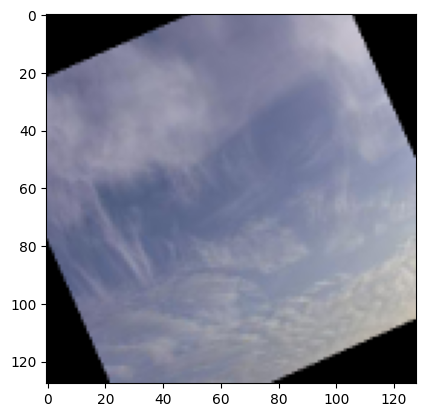

In [67]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
plt.show()

In [68]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [69]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

train_transforms

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomAutocontrast(p=0.5)
    ToTensor()
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
)

In [70]:
dataset_train = ImageFolder(
  "clouds_train",
  transform=train_transforms,
)

dataset_train

Dataset ImageFolder
    Number of datapoints: 474
    Root location: clouds_train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomAutocontrast(p=0.5)
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [71]:
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

dataloader_train

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on device:', device)

Running on device: cpu


In [73]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

net = net.to(device)
net

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=7, bias=True)
)

In [76]:
# The discrepancy between len(dataset_train) and len(dataloader_train)*dataloader_train.batch_size arises because the total number of samples (474) is not exactly divisible by the batch size (16). Therefore, the last batch contains fewer than 16 samples. This is why len(dataloader_train)*dataloader_train.batch_size (480) is slightly larger than len(dataset_train) (474). The difference (480 - 474 = 6) is the number of “empty” spots in the last batch.

len(dataset_train), len(dataloader_train), dataloader_train.batch_size, len(dataloader_train)*dataloader_train.batch_size

(474, 30, 16, 480)

In [75]:
# last_batch = None
# for batch in dataloader_train:
#     last_batch = batch

# # Visualize the last batch
# print("Last batch:")
# print(last_batch)

In [77]:
for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train: # iterate over the number of batches
        images = images.to(device)  # Move images to GPU
        labels = labels.to(device)  # Move labels to GPU
        optimizer.zero_grad()
        outputs = net.forward(images) # or net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train) # divides the epoch loss by the number of batches (average loss per batch per epoch)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.8312
Epoch 2, Loss: 1.4578
Epoch 3, Loss: 1.3232


In [78]:
# For your model
print('Model is on:', next(net.parameters()).device)

# For your data
images, labels = images.to(device), labels.to(device)
print('Data is on:', images.device)


Model is on: cpu
Data is on: cpu


In [79]:
test_transforms = transforms.Compose([
    #
    # NO DATA AUGMENTATION AT TEST TIME 
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

test_transforms

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [80]:
dataset_test = ImageFolder("clouds_test",   transform=test_transforms,)
dataset_test

Dataset ImageFolder
    Number of datapoints: 486
    Root location: clouds_test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [81]:
dataloader_test = DataLoader(
  dataset_test, shuffle=False, batch_size=16
)

dataloader_test

In [82]:
from torchmetrics import Precision, Recall

# Define metrics
# Macro-Averaging: Computes the metric independently for each class and then takes the average
metric_precision = Precision(task="multiclass", num_classes=7, average='macro').to(device)
metric_recall = Recall(task="multiclass", num_classes=7, average='macro').to(device)

metric_precision, metric_recall

(MulticlassPrecision(), MulticlassRecall())

In [88]:
net.eval()
with torch.no_grad(): # doesn't compute gradients at all
    for images, labels in dataloader_test:
        images = images.to(device)  # Move your inputs to the chosen device
        labels = labels.to(device)  # Move your labels to the chosen device
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5519782900810242
Recall: 0.6101225018501282


In [91]:
# torch.max (above) Returns: Two tensors:
# Values: The maximum values along the specified dimension (not used here, hence the _).
# Indices: The indices of the maximum values, which correspond to the predicted class labels.
# example with the last outputs and preds retrieved from the code above
print(outputs)
print(preds)
print(labels)

tensor([[-0.7051, -2.0169, -3.3364,  0.4006,  0.6421,  0.5967,  1.0991],
        [-0.8751, -2.5912, -1.7577,  0.6899,  0.5138,  0.1761,  0.9242],
        [-1.3479, -2.9352, -2.5830,  0.9649,  0.6310,  0.7327,  1.0581],
        [-0.7791, -1.9929, -3.3755, -0.1955,  0.5306,  1.2414,  1.5676],
        [-0.9777, -2.6790, -1.2758,  1.3021,  0.7525, -0.5227,  0.1873],
        [-1.1739, -2.5428, -2.3195,  0.2962,  1.2064,  0.1311,  1.1149]])
tensor([6, 6, 6, 6, 3, 4])
tensor([6, 6, 6, 6, 6, 6])


In [92]:
# Define metrics
# When you initialize the precision metric with average=None in torchmetrics, it calculates the precision per class.
metric_precision = Precision(task="multiclass", num_classes=7, average=None).to(device)

In [93]:
net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)  # Move your inputs to the chosen device
        labels = labels.to(device)  # Move your labels to the chosen device
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        
precision = metric_precision.compute()
precision # visualize the precision for all 7 classes


tensor([0.0000, 0.8077, 0.6429, 0.4588, 0.4167, 0.8537, 0.6842])

In [94]:
precision[0], precision[0].item()

(tensor(0.), 0.0)

In [95]:
dataset_test.class_to_idx.items() # used to access the mapping of class names to their corresponding indices in a dataset

dict_items([('cirriform clouds', 0), ('clear sky', 1), ('cumulonimbus clouds', 2), ('cumulus clouds', 3), ('high cumuliform clouds', 4), ('stratiform clouds', 5), ('stratocumulus clouds', 6)])

In [96]:
# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}

print(precision_per_class)

{'cirriform clouds': 0.0, 'clear sky': 0.807692289352417, 'cumulonimbus clouds': 0.6428571343421936, 'cumulus clouds': 0.45876288414001465, 'high cumuliform clouds': 0.4166666567325592, 'stratiform clouds': 0.8536585569381714, 'stratocumulus clouds': 0.6842105388641357}


In [97]:
# Sequential Data

import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
        # Define inputs
        x = df.iloc[i:(i+seq_length), 1]
        # Define target
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [99]:
train_data = pd.read_csv('electricity_consump/electricity_train.csv')

train_data


,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319
...,...,...
105210,2013-12-31 22:45:00,-0.932595
105211,2013-12-31 23:00:00,-0.907259
105212,2013-12-31 23:15:00,-0.932595
105213,2013-12-31 23:30:00,-0.932595


In [100]:
test_data = pd.read_csv('electricity_consump/electricity_test.csv')

test_data

,timestamp,consumption
0,2014-01-01 00:00:00,-0.932595
1,2014-01-01 00:15:00,-0.957931
2,2014-01-01 00:30:00,-0.932595
3,2014-01-01 00:45:00,-0.907259
4,2014-01-01 01:00:00,-0.881923
...,...,...
35035,2014-12-31 22:45:00,-0.070415
35036,2014-12-31 23:00:00,-0.045079
35037,2014-12-31 23:15:00,-0.045079
35038,2014-12-31 23:30:00,-0.045079


In [101]:
import torch
from torch.utils.data import TensorDataset

# Use create_sequences to create train inputs and targets
X_train, y_train = create_sequences(train_data, 24*4) # a record every 15 minutes
print(X_train.shape, y_train.shape)



(105119, 96) (105119,)


In [103]:
# Use create_sequences to create test inputs and targets
X_test, y_test = create_sequences(test_data, 24*4) # a record every 15 minutes
print(X_test.shape, y_test.shape)

(34944, 96) (34944,)


In [104]:
# Create TensorDataset train
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)
print(len(dataset_train))

X_train, y_train

105119


(array([[-0.70431852, -0.70431852, -0.67898263, ..., -0.65364675,
         -0.72990776, -0.70431852],
        [-0.70431852, -0.67898263, -0.65364675, ..., -0.72990776,
         -0.70431852, -0.70431852],
        [-0.67898263, -0.65364675, -0.70431852, ..., -0.70431852,
         -0.70431852, -0.70431852],
        ...,
        [ 0.79759271,  0.82292859,  0.84826447, ..., -0.93259484,
         -0.93259484, -0.90725895],
        [ 0.82292859,  0.84826447,  0.77200346, ..., -0.93259484,
         -0.90725895, -0.93259484],
        [ 0.84826447,  0.77200346,  0.72133169, ..., -0.90725895,
         -0.93259484, -0.93259484]]),
 array([-0.70431852, -0.70431852, -0.65364675, ..., -0.93259484,
        -0.93259484, -0.93259484]))

In [105]:
# Create TensorDataset test
dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float(),
)
print(len(dataset_test))

X_test, y_test

34944


(array([[-0.93259484, -0.95793072, -0.93259484, ..., -0.93259484,
         -0.93259484, -0.93259484],
        [-0.95793072, -0.93259484, -0.90725895, ..., -0.93259484,
         -0.93259484, -0.93259484],
        [-0.93259484, -0.90725895, -0.88192307, ..., -0.93259484,
         -0.93259484, -0.93259484],
        ...,
        [ 0.92452549,  0.95011473,  0.8991896 , ..., -0.07041469,
         -0.07041469, -0.04507881],
        [ 0.95011473,  0.8991896 ,  0.95011473, ..., -0.07041469,
         -0.04507881, -0.04507881],
        [ 0.8991896 ,  0.95011473,  0.97545061, ..., -0.04507881,
         -0.04507881, -0.04507881]]),
 array([-0.93259484, -0.93259484, -0.93259484, ..., -0.04507881,
        -0.04507881, -0.09575058]))

In [106]:
# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset_train,
    batch_size=16,
    shuffle=True,
)

dataloader_train

In [107]:
# Create a DataLoader based on dataset_test
dataloader_test = DataLoader(
    dataset_test,
    batch_size=16,
    shuffle=False,
)

dataloader_test

In [108]:
for seqs1, labels1 in dataloader_test:
    print("Sequences shape: ", seqs1.shape)
    print("Labels shape: ", labels1.shape)
    break  # remove this line if you want to print shapes for all batches

Sequences shape:  torch.Size([16, 96])
Labels shape:  torch.Size([16])


In [110]:
for seqs1, labels1 in dataloader_train:
    print("Sequences shape: ", seqs1.shape)
    print("Labels shape: ", labels1.shape)
    print(seqs1.size(0), seqs1.size(1))
    break  # remove this line if you want to print shapes for all batches

Sequences shape:  torch.Size([16, 96])
Labels shape:  torch.Size([16])
16 96


In [111]:
# This Net class is a simple implementation of a Recurrent Neural Network (RNN) using PyTorch. It’s designed to take a sequence of numbers as input and return a single output number. The RNN layer processes the sequence, and the final output of this sequence is then passed through a fully connected (Linear) layer to get the final output. The number of features in the hidden state of the RNN is 32, and there are 2 stacked RNNs (i.e., num_layers=2). The batch size is determined by the size of the input x. The initial hidden state is initialized with zeros. The output of the RNN layer is the sequence of hidden states at each time step. The last hidden state of this sequence (i.e., out[:, -1, :]) is passed through the fully connected layer to get the final output. This is a common pattern in sequence-to-one RNNs, where we only care about the output at the final time step. The fully connected layer transforms the RNN output to the desired output size (in this case, 1).


# Importing the necessary libraries
import torch
import torch.nn as nn

# Define the class 'Net' which inherits from 'nn.Module'
class Net_RNN(nn.Module):
    def __init__(self):
        # Call the parent constructor. Necessary for PyTorch to detect this class as a custom module.
        super().__init__()

        # Define a Recurrent Neural Network (RNN) layer
        # input_size=1: The number of expected features in the input x
        # hidden_size=32: The number of features in the hidden state h
        # num_layers=2: Number of recurrent layers (i.e., 2 stacked RNNs)
        # batch_first=True: Whether the first dimension of input represents batch size
        self.rnn = nn.RNN(
            input_size=1, 
            hidden_size=32,
            num_layers=2,
            batch_first=True, # In PyTorch, the input to an RNN is a 3D tensor with dimensions defined as follows:
                            # If batch_first=True, the dimensions are (batch_size, sequence_length, input_size).
                        # If batch_first=False (which is the default), the dimensions are (sequence_length, batch_size, input_size).
        )

        # Define a fully connected layer (Linear layer)
        # It will connect the RNN layer to the output layer
        # 32: The size of each input sample (i.e., the hidden size of the RNN)
        # 1: The size of each output sample
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # Forward propagation function

        # Initialize the first hidden state with zeros
        # 2: The number of layers in the RNN
        # x.size(0): The batch size (i.e., the number of samples per batch)
        # 32: The hidden size of the RNN
        h0 = torch.zeros(2, x.size(0), 32) # x.size(0) returns the size of the first dimension of x, which is the batch size (i.e., the number of sequences in the batch). 

        # Pass the input 'x' and initial hidden states 'h0' through the RNN layer
        # The RNN layer returns the output and the last hidden state
        # We don't need the last hidden state, so we ignore it with '_'
        out, _ = self.rnn(x, h0)

        # Pass the output of the RNN layer through the fully connected (Linear) layer
        # We only want the last time step, so we use 'out[:, -1, :]'
        out = self.fc(out[:, -1, :])

        # Return the final output
        return out


In [113]:
# Create an instance of your class
net = Net_RNN()

net

Net_RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [114]:
# Create some random input data
x = torch.randn(10, 5, 1)  # batch_size=10, sequence_length=5, input_size=1

x

tensor([[[ 1.6122],
         [ 0.2647],
         [-0.7936],
         [-1.1446],
         [ 1.2699]],

        [[-0.4193],
         [ 0.5442],
         [-0.1711],
         [ 0.3101],
         [-0.1650]],

        [[-0.4799],
         [ 1.5505],
         [-0.1157],
         [ 1.3549],
         [-0.7061]],

        [[ 1.1274],
         [ 0.1590],
         [ 2.2384],
         [-0.8105],
         [ 0.5175]],

        [[-0.5689],
         [-0.9515],
         [-1.4914],
         [ 0.6833],
         [-0.7102]],

        [[ 0.5864],
         [-0.3258],
         [-1.1558],
         [-0.7071],
         [ 1.8347]],

        [[ 1.3406],
         [-0.9099],
         [ 0.9877],
         [ 0.6303],
         [-0.5670]],

        [[-0.0657],
         [ 0.2941],
         [-1.3596],
         [ 1.0792],
         [-0.5512]],

        [[ 1.9293],
         [-1.0001],
         [-0.9097],
         [ 0.0598],
         [-0.4854]],

        [[ 0.4494],
         [-0.8370],
         [-1.8607],
         [ 0.3953],
  

In [115]:
# Pass the input data through your network
output = net(x)

output

tensor([[ 0.0312],
        [-0.0729],
        [-0.1295],
        [ 0.0092],
        [-0.0777],
        [ 0.0481],
        [-0.0418],
        [-0.0972],
        [-0.0299],
        [-0.0163]], grad_fn=<AddmmBackward0>)

In [116]:
#GRU

class Net_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out

In [117]:
#LSTM

class Net_LSTM(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [118]:
net_l = Net_LSTM(input_size=1)
# Set up MSE loss
criterion = nn.MSELoss()
optimizer = optim.Adam(
  net.parameters(), lr=0.0001
)

In [119]:
for epoch in range(3):
    for seqs, labels in dataloader_train:
        # Reshape model inputs
        # seqs = seqs.view(16, 96, 1)
        seqs = seqs.view(seqs.size(0), seqs.size(1), 1)
        # Get model outputs
        outputs = net_l(seqs)
        # Compute loss
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 1.1222668886184692
Epoch 2, Loss: 1.3604766130447388
Epoch 3, Loss: 1.1014196872711182


In [ ]:
# net_g = Net_GRU()
# # Set up MSE loss
# criterion = nn.MSELoss()
# optimizer = optim.Adam(
#   net.parameters(), lr=0.0001
# )

In [ ]:
# for epoch in range(3):
#     for seqs, labels in dataloader_train:
#         # Reshape model inputs
#         # seqs = seqs.view(16, 96, 1)
#         seqs = seqs.view(seqs.size(0), seqs.size(1), 1)
#         # Get model outputs
#         outputs = net_g(seqs)
#         # Compute loss
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [120]:
import torchmetrics

# Define MSE metric
mse = torchmetrics.MeanSquaredError()

mse

MeanSquaredError()

In [122]:
net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        # seqs = seqs.view(16, 96, 1)
        seqs = seqs.view(seqs.size(0), seqs.size(1), 1)
        # Pass seqs to net and squeeze the result
        outputs = net_l(seqs).squeeze()
        mse_calc = mse(outputs, labels)
        
print(outputs, mse_calc)


tensor([0.0591, 0.0597, 0.0602, 0.0609, 0.0617, 0.0625, 0.0634, 0.0665, 0.0697,
        0.0723, 0.0721, 0.0710, 0.0699, 0.0689, 0.0681, 0.0676]) tensor(0.1074)


In [123]:
# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")

Test MSE: 0.6713933944702148


In [ ]:
# Model with 2 inputs

In [125]:
import torchvision.datasets as datasets
import os

my_path= os.getcwd()

# Load the Omniglot dataset
omniglot_dataset = datasets.Omniglot(
    root=my_path, 
    download=True,
    # the transform argument is used to ensure that the images from the Omniglot dataset are in the appropriate format and size for input into a PyTorch model.
    transform=transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ])
)


Files already downloaded and verified


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'G:\\My Drive\\Ingegneria\\Data Science GD\\My-Practice\\my models\\NLP\\LLM\\2.Intermediate Deep Learning Pytorch\\omniglot-py\\images_background'

In [ ]:
omniglot_dataset

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Define the path to your dataset
dataset_path = 'G:\\My Drive\\Ingegneria\\Data Science GD\\Models\\DL&LLM\\Intermediate Deep Learning Pytorch\\omniglot-py\\images_background'

# Initialize an empty list to store the tuples
data = []

# Initialize a LabelBinarizer for one-hot encoding of the alphabets
lb = LabelBinarizer()

# Get list of all alphabet directories and fit the LabelBinarizer
all_alphabets = os.listdir(dataset_path)
lb.fit(all_alphabets)

# Initialize a dictionary to store unique labels for each character of every alphabet
char_label_dict = {}
label_counter = 0

# Loop over the directories in the dataset path
for alphabet_dir in all_alphabets:
    alphabet_path = os.path.join(dataset_path, alphabet_dir)
    
    # Loop over the character directories in each alphabet directory
    for character_dir in os.listdir(alphabet_path):
        character_path = os.path.join(alphabet_path, character_dir)
        
        # Assign a unique label to each character of every alphabet
        char_label_key = f"{alphabet_dir}_{character_dir}"
        if char_label_key not in char_label_dict:
            char_label_dict[char_label_key] = label_counter
            label_counter += 1
        
        # Loop over the images in each character directory
        for image_file in os.listdir(character_path):
            image_path = os.path.join(character_path, image_file)
            
            # Create the alphabet vector
            alphabet_vector = lb.transform([alphabet_dir])[0]
            
            # Get the target label
            target_label = char_label_dict[char_label_key]
            
            # Append the tuple to the data list
            data.append((image_path, alphabet_vector, target_label))



In [ ]:
# # Convert the data list to a numpy array
# data = np.array(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Print the first few items in the train_data and test_data to check
print('Train Data:')
for item in train_data[:5]:
    print(item)

print('\nTest Data:')
for item in test_data[:5]:
    print(item)


In [ ]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class OmniglotDataset(Dataset):
    def __init__(self, transform, samples):
		# Assign transform and samples to class attributes
        self.transform = transform
        self.samples = samples
                    
    def __len__(self):
		# Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
      	# Unpack the sample at index idx
        img_path, alphabet, label = self.samples[idx]
        img = Image.open(img_path).convert('L') # convert to grayscale
        # Transform the image 
        img_transformed = self.transform(img) # self.transform(img) is transforming the image img according to the transformations defined in self.transform when the OmniglotDataset object is created
        return img_transformed, alphabet, label

In [ ]:
# Create an instance of your custom dataset

# You’ve already applied the transformations when you loaded the Omniglot dataset using the datasets.Omniglot function. However, the code you’ve shown in the second part is creating a custom dataset class, OmniglotDataset.
# If you’re using the same data (i.e., omniglot_dataset) for both the datasets.Omniglot function and your custom OmniglotDataset class, and you’re applying the same transformations in both places, then you’re effectively transforming the data twice, which is not necessary.

dataset_train = OmniglotDataset(transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
]), samples=train_data)  

dataset_train

In [ ]:
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=3,
)

In [ ]:
next(iter(dataloader_train))

In [ ]:
next(iter(dataloader_train))[0].shape # image

In [ ]:
next(iter(dataloader_train))[1].shape # alphabet (OHE)

In [ ]:
next(iter(dataloader_train))[2].shape # label

In [ ]:
# Import necessary modules
import torch
import torch.nn as nn

# Define the neural network model
class Net_imal(nn.Module):
    def __init__(self):
        super(Net_imal, self).__init__()
        
        # Define the image processing sub-network
        # This network will process the image input
        self.image_layer = nn.Sequential(
            # Convolutional layer with 1 input channel, 16 output channels, 3x3 kernel size, and 1 padding
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            # Max pooling layer with 2x2 window size
            nn.MaxPool2d(kernel_size=2),
            # ELU activation function
            nn.ELU(),
            # Flatten the tensor for the fully connected layer
            nn.Flatten(),
            # Fully connected layer with input size 16*32*32 and output size 128 ----  If the input to the convolutional layer is an image of size 64x64, after the convolutional layer (with padding=1 and kernel_size=3) and the max pooling layer (with kernel_size=2), the output would be of size 16x32x32
            nn.Linear(16*32*32, 128)
        )
        
        # Define the alphabet processing sub-network
        # This network will process the alphabet input
        self.alphabet_layer = nn.Sequential(
            # Fully connected layer with input size 30 and output size 8
            nn.Linear(30, 8),
            # ELU activation function
            nn.ELU(), 
        )
        
        # Define the classifier sub-network
        # This network will classify the processed inputs
        self.classifier = nn.Sequential(
            # Fully connected layer with input size 128 + 8 and output size 964 (number of total characters in all alphabets)
            nn.Linear(128 + 8, 964), 
        )
        
    def forward(self, x_image, x_alphabet):
        # Pass the image input through the image processing sub-network
        x_image = self.image_layer(x_image)
        # Pass the alphabet input through the alphabet processing sub-network
        x_alphabet = self.alphabet_layer(x_alphabet)
        # Concatenate the processed image and alphabet inputs
        x = torch.cat((x_image, x_alphabet), dim=1)
        # Pass the concatenated inputs through the classifier sub-network
        return self.classifier(x)


In [ ]:
net_im_al = Net_imal()
net_im_al

In [ ]:
# remove all the .ipynb_checkpoints folders, that cause errors otherwise

import os
import shutil

def remove_ipynb_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        if '.ipynb_checkpoints' in dirs:
            shutil.rmtree(os.path.join(root, '.ipynb_checkpoints'))


In [ ]:
# Call the function with the directory path
remove_ipynb_checkpoints(my_path)

In [ ]:
outputs = []
for img, alpha, labels in dataloader_train:
    # Ensure the tensors are of the same type
    img = img.type(torch.FloatTensor)
    alpha = alpha.type(torch.FloatTensor)

    output = net_im_al(img, alpha)
    outputs.append(output)


In [ ]:
print(len(outputs))
outputs[:10]

In [ ]:
# model with two outputs (in the samples, the 30 alphabets are one output, and the 964 characters are another outputs, so the alphabets are not OHE anymore, but an integer between 0 and 29)

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define the path to your dataset
dataset_path = 'G:\\My Drive\\Ingegneria\\Data Science GD\\Models\\DL&LLM\\Intermediate Deep Learning Pytorch\\omniglot-py\\images_background'

# Initialize an empty list to store the tuples
data = []

# Get list of all alphabet directories
all_alphabets = os.listdir(dataset_path)

# Initialize a dictionary to store unique labels for each character of every alphabet
char_label_dict = {}
label_counter = 0

# Loop over the directories in the dataset path
for alphabet_dir in all_alphabets:
    alphabet_path = os.path.join(dataset_path, alphabet_dir)
    
    # Loop over the character directories in each alphabet directory
    for character_dir in os.listdir(alphabet_path):
        character_path = os.path.join(alphabet_path, character_dir)
        
        # Assign a unique label to each character of every alphabet
        char_label_key = f"{alphabet_dir}_{character_dir}"
        if char_label_key not in char_label_dict:
            char_label_dict[char_label_key] = label_counter
            label_counter += 1
        
        # Loop over the images in each character directory
        for image_file in os.listdir(character_path):
            image_path = os.path.join(character_path, image_file)
            
            # Create the alphabet vector
            alphabet_vector = all_alphabets.index(alphabet_dir)
            
            # Get the target label
            target_label = char_label_dict[char_label_key]
            
            # Append the tuple to the data list
            data.append((image_path, alphabet_vector, target_label))


In [ ]:
# # Convert the data list to a numpy array
# data = np.array(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Print the first few items in the train_data and test_data to check
print('Train Data:')
for item in train_data[:5]:
    print(item)

print('\nTest Data:')
for item in test_data[:5]:
    print(item)

In [ ]:
# Create dataset_train
dataset_train = OmniglotDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
      	transforms.Resize((64, 64)),
    ]),
    samples=train_data,
)

dataset_train

In [ ]:
# Create dataset_test
dataset_test = OmniglotDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
      	transforms.Resize((64, 64)),
    ]),
    samples=test_data,
)

dataset_test

In [ ]:
# Create dataloader_train
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=32,
)

dataloader_train

In [ ]:
# Create dataloader_test
dataloader_test = DataLoader(
    dataset_test, shuffle=True, batch_size=32,
)

dataloader_test

In [ ]:
next(iter(dataloader_train))[0].shape # image


In [ ]:
next(iter(dataloader_train))[1].shape # alphabet (integer)


In [ ]:
next(iter(dataloader_train))[2].shape # label


In [ ]:
class Net_2o(nn.Module):
    def __init__(self):
        super(Net_2o, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        # Define the two classifier layers
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)
        
    def forward(self, x):
        x_image = self.image_layer(x)
        # Pass x_image through the classifiers and return both results
        output_alpha = self.classifier_alpha(x_image)
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char

In [ ]:
char_weight = 0.9 # more importance to the loss of the characters classification

net = Net_2o()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

for epoch in range(1):
    for images, labels_alpha, labels_char in dataloader_train:
        # Check if any element in images or labels is NaN or Inf
        if torch.isnan(images).any() or torch.isinf(images).any():
            print("NaN or Inf found in images")
        if torch.isnan(labels_alpha).any() or torch.isinf(labels_alpha).any():
            print("NaN or Inf found in labels_alpha")
        if torch.isnan(labels_char).any() or torch.isinf(labels_char).any():
            print("NaN or Inf found in labels_char")

        optimizer.zero_grad()
        outputs_alpha, outputs_char = net(images)

        # Check if any element in outputs is NaN or Inf
        if torch.isnan(outputs_alpha).any() or torch.isinf(outputs_alpha).any():
            print("NaN or Inf found in outputs_alpha")
        if torch.isnan(outputs_char).any() or torch.isinf(outputs_char).any():
            print("NaN or Inf found in outputs_char")

        # Compute alphabet classification loss
        loss_alpha = criterion(outputs_alpha, labels_alpha)
        # Compute character classification loss
        loss_char = criterion(outputs_char, labels_char)

        # Check if any element in losses is NaN or Inf
        if torch.isnan(loss_alpha).any() or torch.isinf(loss_alpha).any():
            print("NaN or Inf found in loss_alpha")
        if torch.isnan(loss_char).any() or torch.isinf(loss_char).any():
            print("NaN or Inf found in loss_char")

        # Compute total loss
        loss = ((1 - char_weight) * loss_alpha) + (char_weight * loss_char)

        # Check if any element in total loss is NaN or Inf
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("NaN or Inf found in total loss")

        loss.backward()

        # Clip gradients to prevent them from exploding
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)

        optimizer.step()


In [ ]:
loss # with char_weight = 0.9

In [ ]:
loss # with char_weight = 0.5

In [ ]:
def evaluate_model(model):
    # Define accuracy metrics
    acc_alpha = Accuracy(task="multiclass", num_classes=30)
    acc_char = Accuracy(task="multiclass", num_classes=964)

    net.eval()
    with torch.no_grad():
        for i, (images, labels_alpha, labels_char) in enumerate(dataloader_test):
            # Obtain model outputs
            outputs_alpha, outputs_char = net(images)
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
            # Update both accuracy metrics
            acc_alpha(pred_alpha, labels_alpha)
            acc_char(pred_char, labels_char)
            
            # Print the values for the first batch of data
            if i == 0:
                print('outputs_alpha', outputs_alpha.size())
                print('pred_alpha', pred_alpha.size())
                print('labels_alpha', labels_alpha.size())
                print('outputs_char', outputs_char.size())
                print('pred_char', pred_char.size())
                print('labels_char', labels_char.size())
                print('outputs_alpha',outputs_alpha)
                print('pred_alpha',pred_alpha)
                print('labels_alpha',labels_alpha)
                print('outputs_char',outputs_char)
                print('pred_char',pred_char)
                print('labels_char',labels_char)

    print(f"Alphabet: {acc_alpha.compute()}")
    print(f"Character: {acc_char.compute()}")


In [ ]:
evaluate_model(net)